# ExampleFit

ExampleFit is an explanation method which explains observations' predicted outcomes by their proximity to example data points.

It transforms a feature space $X$ into a weighting space $W$, where $W_{ij}$ is the weight observation $i$ attaches to example $j$. Weights are normalized such that all $0 < W_{ij} < 1$, and $\sum_j W_{ij}=1$ for all $i$. The more similar observation $i$ and example $j$, the closer $W_{ij}$ is to 1. 

The standard use is to fit a linear model (with no intercept) on the weight space.

We interpret ExampleFit as follows: The more similar observation $i$ and example $j$, the closer the prediction $f(x_i)$ is to $\beta_j$.

**Note**. Because ExampleFit involves stocasticity, you may need to run it a few times before it chooses a sensible set of examples.

In [1]:
from example_fit import ExampleFit

import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Preprocessing.

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Use and performance.

In [3]:
reg = ExampleFit(model=LinearRegression(fit_intercept=False))
reg.fit_validate(X_train, y_train, max_examples=4)
print('Number of examples selected: %i' % reg.examples_X.shape[0])
print('Examples score: %.4f' % r2_score(reg.examples_y, reg.predict(reg.examples_X)))
print('Train score: %.4f' % r2_score(y_train, reg.predict(X_train)))
print('Test score: %.4f' % r2_score(y_test, reg.predict(X_test)))

Number of examples selected: 4
Examples score: 0.9591
Train score: 0.5584
Test score: 0.3846


Comparison to elastic net. Note that ExampleFit has comparable performance using only a few examples and none of the original features.

In [4]:
elastic_net = ElasticNetCV().fit(X_train, y_train)
print('ElasticNet train score: %.4f' % elastic_net.score(X_train, y_train))
print('ElasticNet test score: %.4f' % elastic_net.score(X_test, y_test))

ElasticNet train score: 0.5479
ElasticNet test score: 0.3934


Interpretation.

Here we take an observation $x_i$ from the test data set and predict the value of the target $y_i$. We find the example $j$ to which it is most similar, the weight $w_{ij}$ it assigns to that example, and the coefficient $\beta_j$ on that example.

The closer $x_i$ is to example $j$, the closer the prediction $f(x_i)$ to $\beta_j$.

In [5]:
observation = 0

x = X_test[observation,:].reshape(1,-1)
w = reg.compute_weight(x)
example = w.argmax()
print('Predicted value of y: %.4f' % reg.predict(x)[0])
print('x is most similar to example %i with weight %.4f' % (example, w.max()))
print('The coefficient on example %i is %.4f' % (example, reg.model.coef_[example]))

Predicted value of y: 131.6578
x is most similar to example 0 with weight 0.4621
The coefficient on example 0 is 63.8188


Visualize where the examples fall with respect to the first two principal components.

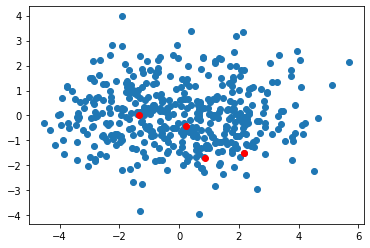

In [6]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2).fit(X_scaled)
X_pc = pca.transform(X_scaled)
example_pc = pca.transform(reg.examples_X)

plt.scatter(X_pc[:,0], X_pc[:,1])
plt.scatter(example_pc[:,0], example_pc[:,1], c='r')